In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
%matplotlib inline

# Model 

There are two states (A,B), hence the process is given by the vector (m,1-m)

The transitions are : 
- B becomes A with probability $1$
- Each A becomes B with probability $\alpha*m$

The fixed point is $m=(\sqrt{1+4\alpha}-1)/(2\alpha)$
- It is a stable fixed point iif $\alpha < 0.75$


1.1102230246251565e-16 0.6666666666666666


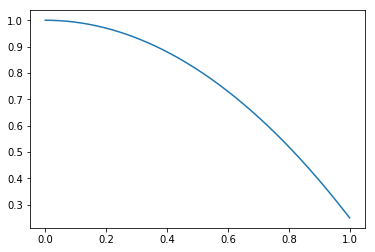

In [2]:
alpha=0.5
alpha=0.75

def phi(m):
    return( 1 - alpha*m**2)

pi = (np.sqrt(1+4*alpha)-1)/(2*alpha)
print(phi( pi ) - pi,pi)

m0 = 0.7

x = np.linspace(0,1,1000)
y = [phi(x) for x in x]
plt.plot(x,y)

# Mean field approximation

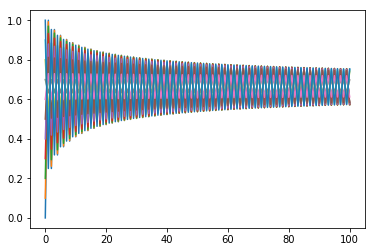

In [3]:
def mean_field(m0,T):
    m = m0
    M=[m0]
    for t in range(T):
        m = phi(m)
        M.append(m)
    return(np.array(M))
for m0 in np.linspace(0,1,11):
    plt.plot(mean_field(m0,100))

# Refined mean field

In [4]:
def A(m):
    return(-2*alpha*m)
def B(m):
    return(-2*alpha)
def Gamma(m):
    return(m*(1-alpha*m)*alpha*m)
def refined_mean_field(m0,T):
    V = [0]
    W = [0]
    M = [m0]
    v = 0
    w = 0
    m = m0
    for t in range(T):
        v = A(m)*v + 1/2 * B(m) * w
        w = Gamma(m) + A(m)*w*A(m)
        m = phi(m)
        M.append(m)
        V.append(v)
        W.append(w)
    return(np.array(M),np.array(V),np.array(W))
m0 = 0.7
(M,V,W) = refined_mean_field(m0,100)

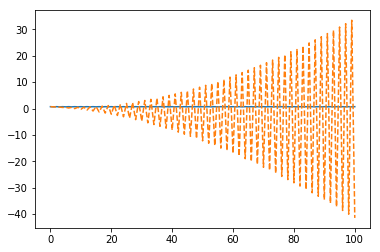

In [5]:
plt.plot(M)
plt.plot(M+V,'--')


# Exact model

The system is composed of N+1 states

In [6]:
def exactMatrix(N):
    M = np.zeros(shape=(N+1,N+1))
    M[0,N] = 1
    for i in range(N+1):
        for j in range(0,i+1):
            M[i,N-j] = binom.pmf(j,i, alpha*(i/N) )
    return(M)
def averageValue(x):
    N = len(x)-1
    return(np.sum(x*np.arange(0,N+1))/N)
def exactAverage(m0,N,T):
    m = np.zeros(N+1)
    m[int(m0*N)] = 1
    M=[averageValue(m)]
    kernel = exactMatrix(N)
    for t in range(T):
        m = np.tensordot(m,kernel,1)
        M.append(averageValue(m))
    return(M)
exactMatrix(2)

array([[0.    , 0.    , 1.    ],
       [0.    , 0.375 , 0.625 ],
       [0.5625, 0.375 , 0.0625]])

0.6892119512552569 0.6838661428382613
0.6976675968679426 0.6967948873783217
0.6399677045500252 0.491258056165802
0.658113886932194 0.6079155324371831


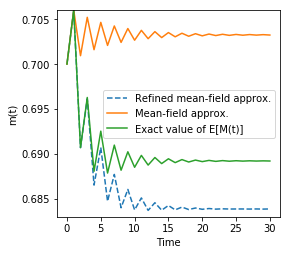

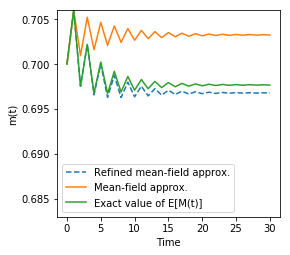

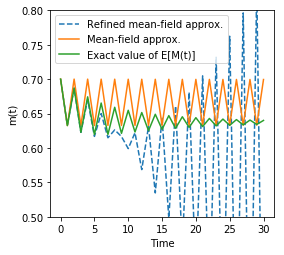

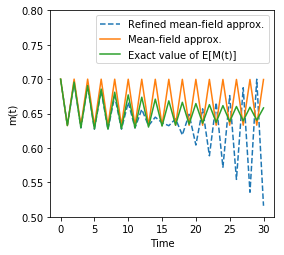

In [7]:
for alpha in [0.6,0.75]:
    for N in [10,30]:
        f = plt.figure()
        f.set_size_inches(4,3.8)
        m0 = 0.7
        M,V,W = refined_mean_field(m0,30)
        Msimu = exactAverage(m0,N,30)
        plt.plot(M+V/(N),'--')
        plt.plot(M,'-')
        plt.plot(Msimu)
        plt.xlabel('Time')
        plt.ylabel('m(t)')
        plt.legend(('Refined mean-field approx.','Mean-field approx.','Exact value of E[M(t)]'))
        if alpha==0.6:
            plt.ylim([0.683,0.706])
        else:
            plt.ylim([0.5,0.8])
        
        f.savefig('unstable1D_a{}_N{}.pdf'.format(int(alpha*100),N),bbox_inches='tight')
        print(Msimu[-1],(M[-1]+M[-2])/2+(V[-1]+V[-2])/2/N)

In [8]:
xSimu = []
myN = np.array([1,2,3,5,10,20,30,50,70,100,120])
for N in myN:
    Msimu = exactAverage(0.3,N,100)
    xSimu.append( (Msimu[-1]+Msimu[-2])/2 )
xSimu = np.array(xSimu)

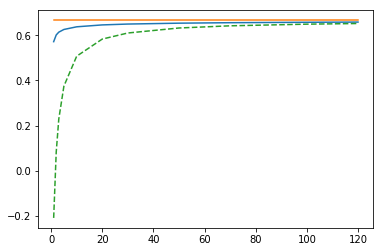

In [9]:
mf = (M[-1]+M[-2])/2
V_th = (V[-1]+V[-2])/2
plt.plot(myN,xSimu)
plt.plot(myN,np.ones(len(myN))*mf)
plt.plot(myN,np.ones(len(myN))*mf+V_th/(1+myN),'--')

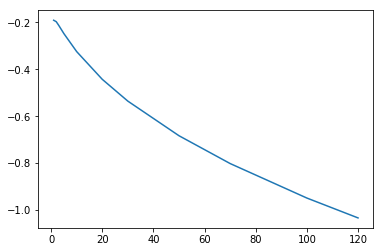

In [10]:
plt.plot(myN,(1+myN)*(xSimu-pi))
#plt.plot(myN,np.ones(len(myN))*V[-1],'--')


# Steady-state 

In the case "$\alpha=0.75$, the convergence to the steady-state seem to be in $O(1/\sqrt{N})$ and not $1/N$. This seems to indicate that this assumption is needed. 

In [15]:
def steady(N):
    A = np.transpose(exactMatrix(N))
    l,x=np.linalg.eig(A)
    ss = x[:,l>.99].reshape((N+1))
    ss = ss/sum(ss)
    #print(ss)
    return(np.real(averageValue(ss)))

In [16]:
for N in [10,20,30,50,100]:
    print(N*(steady(N)-pi))

-0.2948158951010127
-0.42175843856853135
-0.5195203087411548
-0.6747526289922534
-0.960263838400921


In [17]:
errorMF = np.array([(steady(N)-pi) for N in myN])

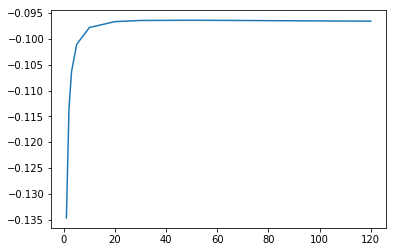

In [18]:
plt.plot(myN,np.array(errorMF)*np.sqrt(1+myN))
